In [289]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import geopandas as gpd
import nomad.visit_attribution as va
import nomad.filters as filters
from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1
import matplotlib.pyplot as plt

In [284]:
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)
sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,
                      parse_dates=True)

In [271]:
# Reproject from gc_coords to web mercator
sparse_df.loc[:,'x'] = (sparse_df['x'] - 4265699)/15
sparse_df.loc[:,'y'] = (sparse_df['y'] + 4392976)/15

diaries_df.loc[:,'x'] = (diaries_df['x'] - 4265699)/15
diaries_df.loc[:,'y'] = (diaries_df['y'] + 4392976)/15

In [272]:
# Select data from 2 users
user1 = diaries_df.uid.unique()[0]
user2 = diaries_df.uid.unique()[10]

sparse1 = sparse_df.loc[sparse_df['uid'] == user1]
sparse2 = sparse_df.loc[sparse_df['uid'] == user2]

diary1 = diaries_df.loc[diaries_df.uid == user1]
diary2 = diaries_df.loc[diaries_df.uid == user2]

In [273]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

In [274]:
completeness_df.q_stat.quantile([0.5, 0.7, 0.85])

0.50    0.381897
0.70    0.490051
0.85    0.578152
Name: q_stat, dtype: float64

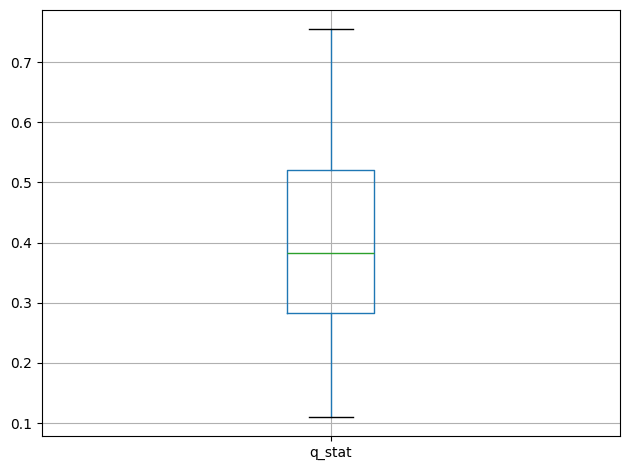

In [275]:
plt.figure()
completeness_df.boxplot(column="q_stat")
plt.grid(True)
plt.tight_layout()

plt.show()

In [276]:
DUR_MIN=5
DT_MAX=60
DELTA_ROAM=100

stop_table_lachesis = LACHESIS.lachesis(traj=sparse1,
                                        dur_min=DUR_MIN,
                                        dt_max=DT_MAX,
                                        delta_roam=DELTA_ROAM,
                                        traj_cols=traj_cols,
                                        keep_col_names=True,
                                        complete_output=True)

labels_lachesis = LACHESIS._lachesis_labels(traj=sparse1,
                                            dur_min=DUR_MIN,
                                            dt_max=DT_MAX,
                                            delta_roam=DELTA_ROAM,
                                            traj_cols=traj_cols)
labels_lachesis.name = 'cluster'

pred_lachesis = va.point_in_polygon(traj=sparse1,
                 labels=labels_lachesis,
                 stop_table=stop_table_lachesis,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

pred_lachesis.location.nunique()

/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'user_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


19

In [277]:
stop_table_hdbscan = HDBSCAN.st_hdbscan(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=60,
                min_pts=2,
                min_cluster_size=3)

labels_hdbscan = HDBSCAN.hdbscan_labels(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=60,
                min_pts=2,
                min_cluster_size=3)

labels_hdbscan.name = 'cluster'

pred_hdbscan = va.point_in_polygon(traj=sparse1,
                 labels=labels_hdbscan,
                 stop_table=stop_table_hdbscan,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

pred_hdbscan.location.nunique()

/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'user_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


17

In [270]:
pred_hdbscan

,start_timestamp,duration,x,y,location
cluster,,,,,
1,1704148860,45,4.265917e+06,-4.392760e+06,None
2,1704158220,199,4.265914e+06,-4.392757e+06,None
3,1704216600,97,4.265912e+06,-4.392832e+06,None
4,1704253920,227,4.265771e+06,-4.392812e+06,None
5,1704287400,34,4.265761e+06,-4.392734e+06,None
6,1704393540,401,4.265917e+06,-4.392851e+06,None
7,1704461580,25,4.265770e+06,-4.392880e+06,None
8,1704507540,21,4.265879e+06,-4.392872e+06,None
9,1704540780,63,4.265769e+06,-4.392727e+06,None


In [260]:
stop_table_hdbscan

,start_timestamp,duration,x,y
cluster,,,,
1,1704148860,45,4.265917e+06,-4.392760e+06
2,1704158220,199,4.265914e+06,-4.392757e+06
3,1704216600,97,4.265912e+06,-4.392832e+06
4,1704253920,227,4.265771e+06,-4.392812e+06
5,1704287400,34,4.265761e+06,-4.392734e+06
6,1704393540,401,4.265917e+06,-4.392851e+06
7,1704461580,25,4.265770e+06,-4.392880e+06
8,1704507540,21,4.265879e+06,-4.392872e+06
9,1704540780,63,4.265769e+06,-4.392727e+06


In [243]:
stop_table_hdbscan = HDBSCAN.st_hdbscan(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=60,
                min_pts=2,
                min_cluster_size=3
            )

labels_hdbscan = HDBSCAN.hdbscan_labels(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=60,
                min_pts=2,
                min_cluster_size=3
            )

labels_hdbscan.name = 'cluster'

va.point_in_polygon(traj=sparse1,
                 labels=labels_hdbscan,
                 stop_table=stop_table_hdbscan,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


,start_timestamp,duration,x,y,location
cluster,,,,,
1,1704093060,260,14.102861,15.973997,h-x13-y13
2,1704133140,25,14.523224,14.154263,h-x13-y13
3,1704151620,222,14.092431,14.681795,h-x13-y13
4,1704177060,68,14.369045,16.770251,w-x14-y15
5,1704192540,89,12.988802,11.686777,h-x13-y9
6,1704223860,53,11.141225,7.511281,h-x11-y8
7,1704232320,76,11.434283,6.846701,h-x11-y8
8,1704291720,38,18.012463,17.851946,w-x16-y18
9,1704315960,80,12.087621,7.433637,h-x11-y8


In [285]:
sparse_df

,uid,timestamp,longitude,latitude,x,y,local_timestamp,ha,date
0,inspiring_beaver,1704093480,38.320071,-36.666358,4.265771e+06,-4.392703e+06,2024-01-01 09:18:00+02:00,11.25,2024-01-01
1,inspiring_beaver,1704093720,38.319979,-36.666396,4.265761e+06,-4.392708e+06,2024-01-01 09:22:00+02:00,11.25,2024-01-01
2,inspiring_beaver,1704095220,38.320034,-36.666405,4.265767e+06,-4.392709e+06,2024-01-01 09:47:00+02:00,11.25,2024-01-01
3,inspiring_beaver,1704097140,38.320061,-36.666418,4.265770e+06,-4.392711e+06,2024-01-01 10:19:00+02:00,11.25,2024-01-01
4,inspiring_beaver,1704097440,38.320072,-36.666500,4.265771e+06,-4.392723e+06,2024-01-01 10:24:00+02:00,11.25,2024-01-01
...,...,...,...,...,...,...,...,...,...
143763,heuristic_lamport,1705739520,38.321248,-36.667898,4.265902e+06,-4.392917e+06,2024-01-20 10:32:00+02:00,11.25,2024-01-20
143764,heuristic_lamport,1705740180,38.321040,-36.667721,4.265879e+06,-4.392892e+06,2024-01-20 10:43:00+02:00,11.25,2024-01-20
143765,heuristic_lamport,1705740780,38.321128,-36.667888,4.265888e+06,-4.392915e+06,2024-01-20 10:53:00+02:00,11.25,2024-01-20
143766,heuristic_lamport,1705741920,38.321133,-36.667800,4.265889e+06,-4.392903e+06,2024-01-20 11:12:00+02:00,11.25,2024-01-20


In [291]:
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
stop_detection_algos = ['lachesis', 'ta-dbscan', 'hdbscan']
metrics_df = pd.DataFrame()
TIME_THRESH=60
DIST_THRESH=5
MIN_PTS=2

DUR_MIN=5
DT_MAX=60
DELTA_ROAM=3

for user in diaries_df.uid.unique()[:10]:
    # truth_df = diaries_df.loc[diaries_df.uid == user].dropna().reset_index(drop=True)
    sparse = sparse_df[sparse_df['uid'] == user]
    sparse.loc[:,'x'] = (sparse['x'] - 4265699)/15
    sparse.loc[:,'y'] = (sparse['y'] + 4392976)/15
    
    truth = diaries_df.loc[diaries_df['uid'] == user]
    truth.loc[:,'x'] = (truth['x'] - 4265699)/15
    truth.loc[:,'y'] = (truth['y'] + 4392976)/15

    for algo in stop_detection_algos:
        if algo == 'lachesis':
            stop_table = LACHESIS.lachesis(
                traj=sparse,
                dur_min=DUR_MIN,
                dt_max=DT_MAX,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols
            )
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dur_min=5,
                dt_max=60,
                delta_roam=3,
                traj_cols=traj_cols
            )
            labels.name = 'cluster'
            # print(algo)
            # print(stop_table)
            # print(labels)
        elif algo == 'ta-dbscan':
            stop_table = TADBSCAN.temporal_dbscan(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols
            )
            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols
            )
            labels.name = 'cluster'
            # print(algo)
            # print(stop_table)
            # print(labels)
        else:  # 'hdbscan'
            stop_table = HDBSCAN.st_hdbscan(
                traj=sparse,
                traj_cols=traj_cols,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3
            )
            labels = HDBSCAN.hdbscan_labels(
                traj=sparse,
                traj_cols=traj_cols,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3
            )
            labels.name = 'cluster'
            # print(algo)
            # print(stop_table)
            # print(labels)
        
        pred = va.point_in_polygon(traj=sparse,
                 labels=labels,
                 stop_table=stop_table,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

        # Step 1: Compute overlaps
        overlaps = overlapping_visits(left=pred,
                                      right=truth,
                                      match_location=False)

        # Step 2: Compute visitation errors (missed, merged, split)
        errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth)

        # Step 3: Compute precision, recall, and F1
        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=pred,
                                           true_visits=truth)

        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        metrics_df = pd.concat([metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory co

In [85]:
sparse_df

,uid,timestamp,longitude,latitude,x,y,local_timestamp,ha,date
0,adoring_keldysh,1704093060,38.321357,-36.666491,4.265914e+06,-4.392721e+06,2024-01-01 09:11:00+02:00,11.25,2024-01-01
1,adoring_keldysh,1704094080,38.321313,-36.666492,4.265909e+06,-4.392721e+06,2024-01-01 09:28:00+02:00,11.25,2024-01-01
2,adoring_keldysh,1704094500,38.321364,-36.666583,4.265915e+06,-4.392734e+06,2024-01-01 09:35:00+02:00,11.25,2024-01-01
3,adoring_keldysh,1704094620,38.321359,-36.666541,4.265914e+06,-4.392728e+06,2024-01-01 09:37:00+02:00,11.25,2024-01-01
4,adoring_keldysh,1704095100,38.321314,-36.666566,4.265909e+06,-4.392732e+06,2024-01-01 09:45:00+02:00,11.25,2024-01-01
...,...,...,...,...,...,...,...,...,...
26844,stoic_johnson,1704702600,38.320663,-36.667877,4.265837e+06,-4.392914e+06,2024-01-08 10:30:00+02:00,11.25,2024-01-08
26845,stoic_johnson,1704702720,38.320646,-36.667780,4.265835e+06,-4.392900e+06,2024-01-08 10:32:00+02:00,11.25,2024-01-08
26846,stoic_johnson,1704702780,38.320632,-36.667780,4.265833e+06,-4.392900e+06,2024-01-08 10:33:00+02:00,11.25,2024-01-08
26847,stoic_johnson,1704702840,38.320698,-36.667836,4.265841e+06,-4.392908e+06,2024-01-08 10:34:00+02:00,11.25,2024-01-08


In [292]:
metrics_df

,missed_fraction,merged_fraction,split_fraction,precision,recall,f1,user,algorithm
0,0.904645,0.004890,0.014670,0.998588,0.127525,0.226168,admiring_curie,lachesis
1,0.914425,0.034230,0.014670,0.994269,0.131421,0.232157,admiring_curie,ta-dbscan
2,0.889976,0.041565,0.024450,0.987483,0.130916,0.231183,admiring_curie,hdbscan
3,0.908277,0.004474,0.006711,0.995639,0.115296,0.206660,adoring_keldysh,lachesis
4,0.901566,0.038031,0.006711,0.986041,0.119769,0.213594,adoring_keldysh,ta-dbscan
5,0.901566,0.017897,0.022371,0.990012,0.121573,0.216553,adoring_keldysh,hdbscan
6,0.762836,0.036675,0.061125,0.996122,0.342857,0.510131,adoring_newton,lachesis
7,0.757946,0.132029,0.048900,0.985820,0.351118,0.517809,adoring_newton,ta-dbscan
8,0.740831,0.092910,0.088020,0.987251,0.405051,0.574425,adoring_newton,hdbscan
9,0.784270,0.026966,0.042697,0.995869,0.234812,0.380021,adoring_northcutt,lachesis


<Figure size 640x480 with 0 Axes>

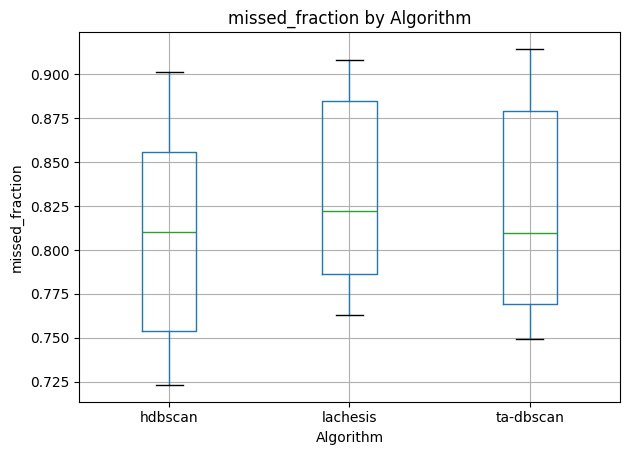

<Figure size 640x480 with 0 Axes>

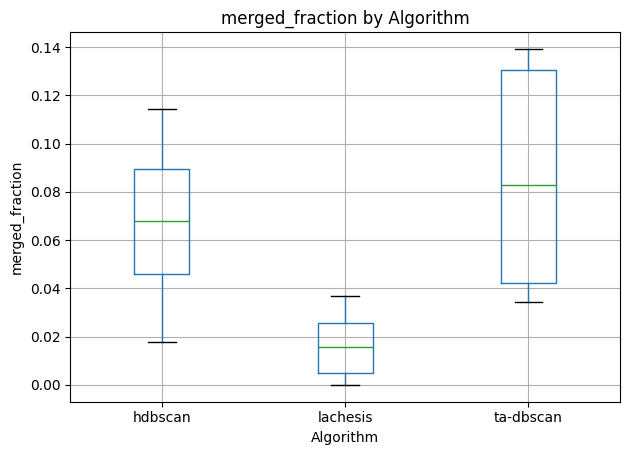

<Figure size 640x480 with 0 Axes>

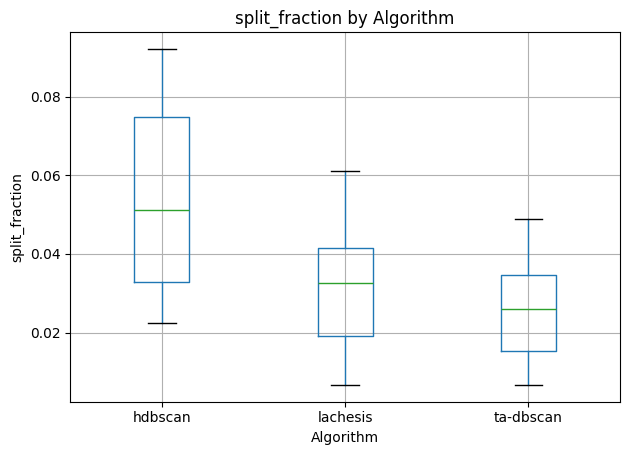

<Figure size 640x480 with 0 Axes>

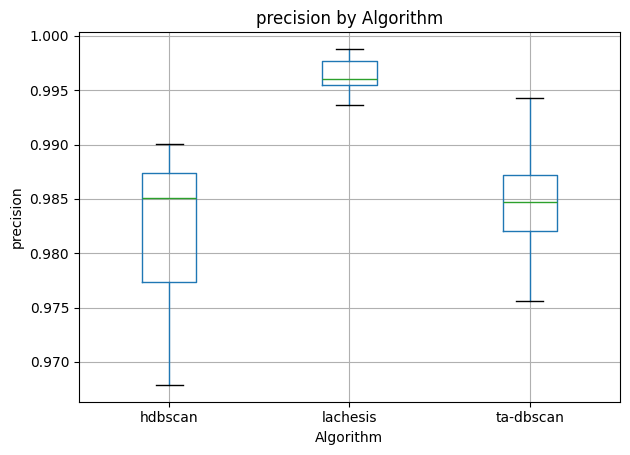

<Figure size 640x480 with 0 Axes>

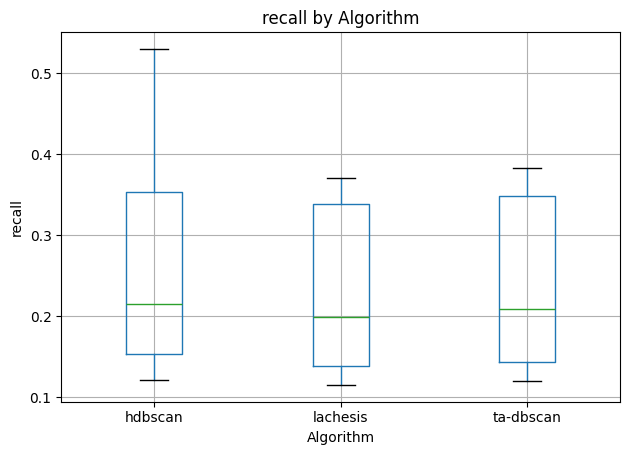

<Figure size 640x480 with 0 Axes>

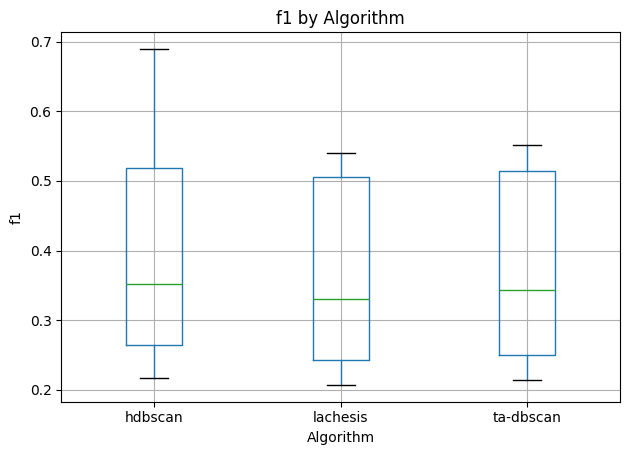

In [293]:
metrics = ["missed_fraction", "merged_fraction", "split_fraction", "precision", "recall", "f1"]

for metric in metrics:
    plt.figure()
    metrics_df.boxplot(column=metric, by='algorithm')
    plt.title(f'{metric} by Algorithm')
    plt.suptitle('')
    plt.xlabel('Algorithm')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()

plt.show()